In [ ]:
import mne
import mne_bids
import os, os.path as op
import matplotlib.pyplot as plt
import numpy as np

# Load in the data

In [ ]:
datadir = '/Users/nugenta/'

In [ ]:
%matplotlib inline

In [ ]:
bids_root = op.join(datadir, 'meg_workshop_data')
deriv_root = op.join(bids_root, 'derivatives')
project_root = op.join(deriv_root, 'Day1')
fs_subjects_dir = op.join(deriv_root,'freesurfer','subjects')

In [ ]:
subject='ON03748'

In [ ]:
bids_path = mne_bids.BIDSPath(root=bids_root, subject = subject, session='01', 
                              task='airpuff', run='01', datatype='meg')
bids_deriv_path = bids_path.copy().update(root=deriv_root, check=False)

In [ ]:
raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()

## Get a feel for how different filtering operations change the data and the spectrum

In [ ]:
# try plotting the raw data
raw.plot()

In [ ]:
# You can see data without 3rd gradient compensation to see low frequency environmental noise
raw.apply_gradient_compensation(0)
raw.plot()

In [ ]:
# turn 3rd gradient back on
raw.apply_gradient_compensation(3)

In [ ]:
# pick MEG channels
meg_picks=mne.pick_types(raw.info, meg=True)

In [ ]:
# effects of filtering 
lowpass = raw.copy()  # always make a copy of the data because otherwise, MNE will alter the raw data in place
lowpass.filter(l_freq = None, h_freq = 45,picks=meg_picks)
highpass = raw.copy()
highpass.filter(l_freq = 1, h_freq = None,picks=meg_picks)
notch=raw.copy()
notch.notch_filter(freqs=[60,120,180,240],picks=meg_picks)
bandpass = raw.copy()
bandpass.filter(l_freq = 1, h_freq = 40,picks=meg_picks)

In [ ]:
# plot the PSD's of the different datasets - change this cell to look at all the datasets
# you can also change the window of the spectrum you plot with fmin, fmax 

# You can either plot all channels overlaid with average=False or all channels averaged wiht average=True

tmp=lowpass.compute_psd(fmax=250,n_fft=1024).plot(average=True)
lowpass.plot()

In [ ]:
# You can also resample the dataset

# If you are only interested in frequencies below 50Hz, but your data is sampled at 1200Hz, 
# you have more data than you need, and you can downsample. 

# But downsampling raw can cause problems with event markers!
# And, downsampling epoched data can case artifacts at the start and end of epochs!

# There are ways around this, but it's often better to just not downsample the data

In [ ]:
# I'll make some bandpassed datasets for later
alpha = raw.copy().filter(l_freq=8,h_freq=12)
theta = raw.copy().filter(l_freq=4,h_freq=8)

## Time Frequency Analysis

In [ ]:
# First, we have to get the data epoched by trial
events, event_ids = mne.events_from_annotations(raw)
epochs = mne.Epochs(bandpass, events, tmin = -0.1, tmax=0.3, event_id=event_ids, preload=True)

In [ ]:
# here are the event ID's
event_ids

In [ ]:
# Average all the epochs to create a evoked response. This will only preserve events that are time/phase
# locked to the onset of the stimulus. Everything else, including oscilliatory power changes will average out
evoked_stim = epochs['stim'].average()
evoked_missingstim = epochs['missingstim'].average()

In [ ]:
# plot the evoked response of the stimulus
tmp=evoked_stim.plot()

In [ ]:
# and the missing stim
tmp=evoked_missingstim.plot()

In [ ]:
# We can also do a time-frequency analysis
#
# This uses a sliding temporal window
# The length of the window is defined by the frequencies desired and the number of cycles of each frequency
#
# You can try playing around with this. 
# see: https://mne.tools/stable/auto_examples/time_frequency/time_frequency_simulated.html 

In [ ]:
freqs = np.arange(4,20,1)   # frequencies to estimate
n_cycles = freqs/4          # number of cycles
time_bandwidth=2            # the product of the window length * full frequency bandwidth
                            # lower = less smoothing

In [ ]:
power_stim=mne.time_frequency.tfr_multitaper(epochs['stim'], average=True, n_jobs=4, return_itc=False,
                                        freqs=freqs,n_cycles=n_cycles,time_bandwidth=time_bandwidth)

In [ ]:
power_missingstim=mne.time_frequency.tfr_multitaper(epochs['missingstim'], average=True, n_jobs=4, 
                                                    return_itc=False, freqs=freqs,n_cycles=n_cycles,
                                                    time_bandwidth=time_bandwidth)

In [ ]:
# you can also play with different time frequency methods
power_morlet=mne.time_frequency.tfr_morlet(epochs['stim'], average=True, n_jobs=4, return_itc=False,
                                        freqs=freqs,n_cycles=n_cycles)

In [ ]:
# lets pick a sensor (75 is good!) and plot the evoked data for both stimuli
plt.plot(evoked_stim._data[75,:],label='stim')
plt.plot(evoked_missingstim._data[75,:],label='missing stim')
plt.legend()

In [ ]:
# Now, you can look at the time frequency plots. Uncomment the one you want to see
# Note that even though there's not much of an evoked response for the missing stimulus, 
# we do see some power changes
power_stim.plot([75])
#power_missingstim.plot([75])
#power_morlet.plot([75])

In [ ]:
#  We can also plot the time frequency plot of the difference
power_diff = power_stim - power_missingstim
power_diff.plot([75])

In [ ]:
# Based on what we see above, lets look at power in alpha and theta
epochs_theta = mne.Epochs(theta, events, tmin = -0.1, tmax=0.3, event_id=event_ids, preload=True)
epochs_alpha = mne.Epochs(alpha, events, tmin = -0.1, tmax=0.3, event_id=event_ids, preload=True)

In [ ]:
# We can subtract off the evoked response so we just look at induced power
epochs_theta.subtract_evoked()
epochs_theta.apply_hilbert(envelope=True)
epochs_alpha.subtract_evoked()
epochs_alpha.apply_hilbert(envelope=True)

In [ ]:
# Just for the sake of the exercise, let's look at the average power in the same channel we used above

average_theta_stim=epochs_theta['stim'].average()
average_theta_missingstim=epochs_theta['missingstim'].average()
times=average_theta_stim.times
average_theta_stim=mne.baseline.rescale(average_theta_stim.data[75,:],times,baseline=(None,0))
average_theta_missingstim=mne.baseline.rescale(average_theta_missingstim.data[75,:],times,baseline=(None,0))

average_alpha_stim=epochs_alpha['stim'].average()
average_alpha_missingstim=epochs_alpha['missingstim'].average()
average_alpha_stim=mne.baseline.rescale(average_alpha_stim.data[75,:],times,baseline=(None,0))
average_alpha_missingstim=mne.baseline.rescale(average_alpha_missingstim.data[75,:],times,baseline=(None,0))


In [ ]:
# We can see that there's actually more alpha power for the missing stim condition, while theta
# is the same

# We can't do statistics here because we have one subject and one channel, but this should give you a feel for 
# evoked responses and induced power changes and how those look in your data

plt.subplot(211)
plt.title('alpha')
tmp=plt.plot(times[5:-5],average_alpha_stim[5:-5],label='stim')
tmp=plt.plot(times[5:-5],average_alpha_missingstim[5:-5],label='missingstim')
tmp=plt.plot(times[5:-5],average_alpha_stim[5:-5]-average_alpha_missingstim[5:-5],label='stim-missingstim')
plt.legend()
plt.subplot(212)
plt.title('theta')
tmp=plt.plot(times[5:-5],average_theta_stim[5:-5],label='stim')
tmp=plt.plot(times[5:-5],average_theta_missingstim[5:-5],label='missingstim')
tmp=plt.plot(times[5:-5],average_theta_stim[5:-5]-average_theta_missingstim[5:-5],label='stim-missingstim')
plt.legend()
plt.tight_layout()

# Let's talk about artifacts!

In [ ]:
subject='ON62003'
bids_path = mne_bids.BIDSPath(root=bids_root, subject = subject, session='01', 
                              task='airpuff', run='01', datatype='meg')
bids_deriv_path = bids_path.copy().update(root=deriv_root, check=False)
raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()

In [ ]:
# plot the data and scroll down to the temporal channels - you'll see lots of eye blinks
raw.plot()

In [ ]:
raw.info['ch_names'][140], raw.info['ch_names'][270]

In [ ]:
# here's a left temporal sensor and a right temporal sensor centered on some blinks
plt.subplot(121)
plt.plot(raw._data[140,30000:60000])
plt.subplot(122)
plt.plot(raw._data[270,30000:60000])

In [ ]:
# Let's use ICA to see if we can isolate these artifacts
# We always want to filter the data first to remove low frequency drifts
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=40)
# normally you wouldn't select a random state - I'm doing that so that you always get the same component numbers
ica = mne.preprocessing.ICA(n_components=20, max_iter="auto", random_state=74)
ica.fit(filt_raw)

In [ ]:
# This gives the variance in the data that is explained by all the ICA components, and the 
# variance explained by just the first component
ica.get_explained_variance_ratio(filt_raw), ica.get_explained_variance_ratio(filt_raw, components=[0])

In [ ]:
# We can plot the ICA component maps
# Clearly, component 0 is eyeblink. Components 1, 6, and 7 also look suspicious for cardiac
ica.plot_components()

In [ ]:
# This will plot the sources. You can right click on any component to see the topo map
# you can see from the time courses that 1 is clearly an artifact, and 6 and 7 are cardiac
ica.plot_sources(raw)

In [ ]:
# Let's look at the effects of removing those components
tmp=ica.plot_overlay(filt_raw, exclude=[0,1,6,7])

In [ ]:
# set which components you want to remove, and create a copy of the raw data and apply the ICA
ica.exclude = [0,1,6,7]
raw_clean=raw.copy()
ica.apply(raw_clean)

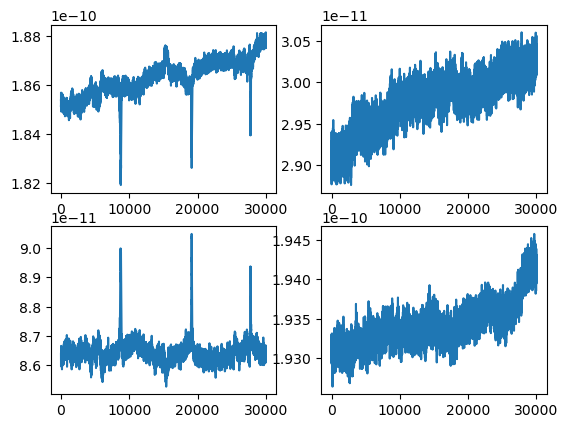

In [494]:
# here's the raw data from those temporal sensors, and the cleaned data
plt.subplot(221)
plt.plot(raw._data[140,30000:60000])
plt.subplot(222)
plt.plot(raw_clean._data[140,30000:60000])
plt.subplot(223)
plt.plot(raw._data[270,30000:60000])
plt.subplot(224)
plt.plot(raw_clean._data[270,30000:60000])